In [341]:
import sys
import time
import numpy as np
import tensorly as tl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from brokenaxes import brokenaxes
from tensorly.decomposition import parafac
from tensorly.decomposition.candecomp_parafac import initialize_factors, unfolding_dot_khatri_rao, KruskalTensor

In [2]:
# for sample video
from cv2 import VideoWriter, VideoWriter_fourcc

def make_video(tensor, filename):
    start = time.time()
    height = tensor.shape[1]
    width = tensor.shape[2]
    FPS = 24

    fourcc = VideoWriter_fourcc(*'MP42')
    video = VideoWriter(filename, fourcc, float(FPS), (width, height))

    for frame in tensor:
        video.write(np.uint8(frame))
    video.release()
    print('created', filename, time.time()-start)

In [3]:
import math
class Welford(object):
    def __init__(self,lst=None):
        self.k = 0
        self.M = 0
        self.S = 0
        
        self.__call__(lst)
    
    def update(self,x):
        if x is None:
            return
        self.k += 1
        newM = self.M + (x - self.M)*1./self.k
        newS = self.S + (x - self.M)*(x - newM)
        self.M, self.S = newM, newS

    def consume(self,lst):
        lst = iter(lst)
        for x in lst:
            self.update(x)
    
    def __call__(self,x):
        if hasattr(x,"__iter__"):
            self.consume(x)
        else:
            self.update(x)
            
    @property
    def mean(self):
        return self.M
    @property
    def meanfull(self):
        return self.mean, self.std/math.sqrt(self.k)
    @property
    def std(self):
        if self.k==1:
            return 0
        return math.sqrt(self.S/(self.k-1))
    def __repr__(self):
        return "<Welford: {} +- {}>".format(self.mean, self.std)

In [4]:
def construct_tensor(factors):
    weights = tl.ones(factors[0].shape[1])
    est_tensor = tl.kruskal_to_tensor((weights, factors))
    return est_tensor
    
def print_tensor(X, n_digit=1):
    print(np.round(X, n_digit))
    
def compare_tensors(A, B):
    error_norm = tl.norm(A - B)
    print('||A-B||:', error_norm)
    return error_norm
    
def create_tensor_stream(X, start_to_stream, batch_sizes):
    total_batch_size = np.sum(batch_sizes)
    if X.shape[0] != start_to_stream + total_batch_size:
        raise ValueError('Total batch size should be the size of streaming part of the tensor.')
    
    X_stream = [X[:start_to_stream]]
    batch_start = start_to_stream
    for batch_size in batch_sizes:
        batch_end = batch_start + batch_size
        X_stream.append(X[batch_start:batch_end])
        batch_start = batch_end
    return np.asarray(X_stream)
    
def get_KhatriRao(factors):
    n_dim = len(factors)
    lefts = [factors[n_dim-1]]
    rights = [factors[0]]
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            lefts.append(tl.tenalg.khatri_rao((lefts[mode-1], factors[n_dim-mode-1])))
            rights.append(tl.tenalg.khatri_rao((factors[mode], rights[mode-1])))
            
    K = lefts.copy()
    K[0] = lefts[n_dim-2]
    K.append(rights[n_dim-2].copy())
    if n_dim > 2:
        for mode in range(1, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((lefts[n_dim-mode-2], rights[mode-1]))
    return K

def get_KhatriRao_except0(factors):
    n_dim = len(factors)
    lefts = np.empty((n_dim), dtype=object)
    rights = np.empty((n_dim), dtype=object)
    K = np.empty((n_dim), dtype=object)
    
    lefts[1] = factors[n_dim-1]
    rights[1] = factors[1]
    if n_dim > 3:
        for mode in range(2, n_dim-1):
            lefts[mode] = tl.tenalg.khatri_rao((factors[n_dim-mode], lefts[mode-1]))
            rights[mode] = tl.tenalg.khatri_rao((rights[mode-1], factors[mode]))
            
    K[1] = lefts[n_dim-2]
    K[n_dim-1] = rights[n_dim-2]
    if n_dim > 3: 
        for mode in range(2, n_dim-1):
            K[mode] = tl.tenalg.khatri_rao((rights[mode-1], lefts[n_dim-mode-1]))
    return K
    
def get_Hadamard(factors):
    rank = factors[0].shape[1]
    H = tl.tensor(np.ones((rank, rank)))
    for factor in factors:
        H = H * tl.dot(tl.transpose(factor), factor)
    return H

### Online CP

In [5]:
def online_cp(factors_old, X_old, X_new, rank, P, Q, n_iter=1, mu=1, verbose=False, transformed=False):
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    if not transformed:
        K = get_KhatriRao_except0(factors_old)
    H = get_Hadamard(factors_old[1:])
        
    for i in range(n_iter):
        # temporal mode for A1
        if not transformed:
            mttkrp = tl.dot(tl.unfold(X_new, 0), tl.tenalg.khatri_rao((U[1], K[1])))
        else:
            # for higher accracy, lower speed
            mttkrp_parts = []
            for r in range(rank):
                component = tl.tenalg.multi_mode_dot(X_new, [f[:, r] for f in U], skip=0)
                mttkrp_parts.append(component)
            mttkrp = np.stack(mttkrp_parts, axis=1)
        
        A1 = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            
            if not transformed:
                dP = tl.dot(tl.unfold(X_new, mode), tl.tenalg.khatri_rao((A1, K[mode])))
                UTU  = tl.dot(tl.transpose(U[mode]), U[mode])
                dQ = tl.dot(tl.transpose(A1), A1) * H / UTU
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(mu*Q[mode] + dQ), tl.transpose(mu*P[mode] + dP)))
                P[mode] = P[mode] + dP
                Q[mode] = Q[mode] + dQ
            else:
                U1 = U.copy()
                U1[0] = A1
                
                H_mode  = H / tl.dot(tl.transpose(U[mode]), U[mode])
                V = (mu * tl.dot(tl.transpose(U[0]), U[0]) + tl.dot(tl.transpose(A1), A1)) * H_mode
                
                mttkrp0 = unfolding_dot_khatri_rao(X_old, (None, U), mode)
                mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
                
                U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mu*mttkrp0 + mttkrp1)))
                H = H_mode * tl.dot(tl.transpose(U[mode]), U[mode])
                
        # temporal mode for A0
        if transformed:
            mttkrp = unfolding_dot_khatri_rao(X_old, (None, U), 0)
            U[0] = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
            
        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0], A1))
    return (KruskalTensor((weights, U)), P, Q)

### DTD

In [6]:
def dtd(factors_old, X_old, X_new, rank, n_iter=1, mu=1, verbose=False):
    
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    for i in range(n_iter):
        # temporal mode for A1
        V = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
        mttkrp = unfolding_dot_khatri_rao(X_new, (None, U), 0)
        A1 = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))

        # non-temporal mode
        for mode in range(1, n_dim):
            U1 = U.copy()
            U1[0] = A1
            V = tl.tensor(np.ones((rank, rank)))
            W = tl.tensor(np.ones((rank, rank)))
            for j, factor in enumerate(U):
                factor_old = factors_old[j]
                if j != mode:
                    W = W * tl.dot(tl.transpose(factor_old), factor)
                    if j == 0:
                        V = V * (mu*tl.dot(tl.transpose(factor), factor) + tl.dot(tl.transpose(A1), A1))
                    else:
                        V = V * tl.dot(tl.transpose(factor), factor)
            mttkrp0 = mu * tl.dot(factors_old[mode], W)
            mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
            U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp0 + mttkrp1)))

        # temporal mode for A0
        V = tl.tensor(np.ones((rank, rank)))
        W = tl.tensor(np.ones((rank, rank)))
        for j, factor in enumerate(U):
            factor_old = factors_old[j]
            if j != 0:
                V = V * tl.dot(tl.transpose(factor), factor)
                W = W * tl.dot(tl.transpose(factor_old), factor)
        mttkrp = tl.dot(factors_old[0], W)
        U[0] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp)))
        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0].copy(), A1))
    return KruskalTensor((weights, U))

### Adaptive

In [7]:
def adaptive_online_cp(factors_old, X_old, X_new, rank, n_iter=1, mu=1, verbose=False):
    
    weights = tl.ones(rank)
    if verbose:
        X = tl.tensor(np.concatenate((X_old, X_new)))
    n_dim = tl.ndim(X_old)
    U = factors_old.copy()
    
    H = get_Hadamard(U[1:])
    G = H
    
    ATA0 = tl.dot(tl.transpose(U[0]), U[0])
    ATA1 = tl.dot(tl.transpose(U[1]), U[1])
    
    for i in range(n_iter):        
        # temporal mode for A1
        mttkrp_parts = []
        for r in range(rank):
            component = tl.tenalg.multi_mode_dot(X_new, [f[:, r] for f in U], skip=0)
            mttkrp_parts.append(component)
        mttkrp = np.stack(mttkrp_parts, axis=1)
        
        A1 = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
        ATA1 = tl.dot(tl.transpose(A1), A1)
        
        
        # non-temporal mode
        for mode in range(1, n_dim):
            
            U1 = U.copy()
            U1[0] = A1
                    
            G = G / tl.dot(tl.transpose(factors_old[mode]), U[mode])
            W = G * tl.dot(tl.transpose(factors_old[0]), U[0])
            mttkrp0 = mu * tl.dot(factors_old[mode], W)
            mttkrp1 = unfolding_dot_khatri_rao(X_new, (None, U1), mode)
            
            H = H / tl.dot(tl.transpose(U[mode]), U[mode])
            V = H * (mu * ATA0 + ATA1)
            U[mode] = tl.transpose(tl.solve(tl.transpose(V), tl.transpose(mttkrp0 + mttkrp1)))
            G = G * tl.dot(tl.transpose(factors_old[mode]), U[mode])
            H = H * tl.dot(tl.transpose(U[mode]), U[mode])
            

        # temporal mode for A0        
        mttkrp = tl.dot(factors_old[0], G)
        U[0] = tl.transpose(tl.solve(tl.transpose(H), tl.transpose(mttkrp)))
        ATA0 = tl.dot(tl.transpose(U[0]), U[0])

        if verbose:
            U1 = U.copy()
            U1[0] = np.concatenate((U[0], A1))
            X_est = construct_tensor(U1)
            compare_tensors(X, X_est)

    U[0] = np.concatenate((U[0].copy(), A1))
    return KruskalTensor((weights, U))

## Online Tensor Decomposition
* `adaptive_onlinecp`, `dtd`

In [244]:
from warnings import warn

def get_z_score(x, mean, std):
    if std == 0:
        return 0
    return (x - mean) / std

def online_tensor_decomposition(dataset, X, X_stream, rank, n_iter=1, ul=-1, ll=-1, verbose=False, methods=['dao', 'dtd', 'ocp', 'fcp']):
    results = {}
    start = time.time()
    (weights, factors_old) = parafac(X_stream[0], rank, init='random')
    print('-----------------------------------')
    print('making init decomposition result:', time.time()-start)
    
    for method in methods:

        print('\n >> {} rank-{} n_iter-{}'.format(method, rank, n_iter))
        
        factors = factors_old
        X_old = X_stream[0]
        n_dim = tl.ndim(X_old)
        if not method in ['dao', 'dtd', 'ocp', 'fcp']:
            raise ValueError('The method does not exist.')  
        if method == 'fcp':
            (weights, factors) = parafac(X, rank, init='random')
            X_est = construct_tensor(factors)
            err_norm = tl.norm(X - X_est)
            global_rt = time.time()-start
            global_fit = 1 - (err_norm/tl.norm(X))
            print('global fitness', global_fit)
            print('global running time', global_rt)
            results[method] = [global_fit, 0, global_rt, 0]
            continue

        ktensors = []
        verbose_list = []
        split_points = []
        refine_points = []
        fitness = []
        running_time = []
        begin = time.time()

        welford = Welford()
        X_est = construct_tensor(factors)
        err_norm = tl.norm(X_old - X_est)
        welford(err_norm * 1.2)


        if method == 'ocp':
            start = time.time()
            K = get_KhatriRao_except0(factors)
            H = get_Hadamard(factors)

            P = np.empty((n_dim), dtype=object)
            Q = np.empty((n_dim), dtype=object)

            for mode in range(1, n_dim):
                P[mode] = tl.dot(tl.unfold(X_old, mode), tl.tenalg.khatri_rao((factors[0], K[mode])))
                Q[mode] = H / tl.dot(tl.transpose(factors[mode]), factors[mode])
            #print('init_time:', time.time()-start)

        
        for i, X_new in enumerate(X_stream[1:]):

            start = time.time()
            if method == 'dao':
                (weights, factors0) = adaptive_online_cp(factors.copy(), X_old, X_new, rank, n_iter=n_iter, mu=0.8, verbose=False)
            elif method == 'ocp':
                ((weights, factors0), P0, Q0) = online_cp(factors.copy(), X_old, X_new, rank, P, Q, verbose=False)
            elif method == 'dtd':
                (weights, factors0) = dtd(factors.copy(), X_old, X_new, rank, verbose=False)

            U = factors0.copy()
            U[0] = U[0][-X_new.shape[0]-1:-1]
            dX_est = construct_tensor(U)

            err_norm = tl.norm(X_new - dX_est)
            z_score = get_z_score(err_norm, welford.mean, welford.std)

            if method == 'dao' and ul > 0 and z_score > ul:
                weights = tl.ones(rank)
                ktensors.append(KruskalTensor((weights, factors.copy())))
                #print('=== SPLIT({}, {}) ==='.format(z_score, err_norm))
                split_points.append(i+1)

                X_old = X_stream[i+1]

                (weights, factors0) = parafac(X_old, rank, init='random')
                elapsed_time = time.time()-start
                #print('making init decomposition result:', time.time()-start)
                verbose_list.append([i+1, elapsed_time, err_norm, z_score])

                start = time.time()
                X_est = construct_tensor(factors0)
                err_norm = tl.norm(X_old - X_est)
                welford = Welford()
                welford(err_norm * 1.2)

                z_score = get_z_score(err_norm, welford.mean, welford.std)
                factors = factors0.copy()
                welford(err_norm)
                elapsed_time = time.time()-start
                #print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
                verbose_list.append([i+1, elapsed_time, err_norm, z_score])
                fitness.append(err_norm/tl.norm(X_new))
                running_time.append(elapsed_time)
                continue
            elif method == 'dao' and ll > 0 and z_score > ll:
                #print('=== REFINE({}, {}) ==='.format(z_score, err_norm))
                refine_points.append(i+1)
                elapsed_time = time.time()-start
                verbose_list.append([i+1, elapsed_time, err_norm, z_score])

                (weights, factors) = adaptive_online_cp(factors, X_old, X_new, rank, n_iter=n_iter*2, mu=0.1, verbose=False)
                
                U = factors.copy()
                U[0] = U[0][-X_new.shape[0]-1:-1]
                dX_est = construct_tensor(U)
                err_norm = tl.norm(X_new - dX_est)
                welford(err_norm)
            else:
                if method == 'ocp':
                    P = P0
                    Q = Q0
                factors = factors0.copy()
                welford(err_norm)
            
            elapsed_time = time.time()-start
            #print('{}th_iter:'.format(i+1), elapsed_time, err_norm, z_score)
            verbose_list.append([i+1, elapsed_time, err_norm, z_score])
            fitness.append(err_norm/tl.norm(X_new))
            running_time.append(elapsed_time)
            X_old = tl.concatenate((X_old, X_new))

            if verbose:
                X_est = construct_tensor(factors)
                compare_tensors(X_old, X_est)

        weights = tl.ones(rank)
        ktensors.append(KruskalTensor((weights, factors)))
        
#     return (ktensors, np.asarray(verbose_list))
        global_rt = time.time() - begin

        tensor_est = construct_tensor(ktensors[0][1])
        for (weights, factors) in ktensors[1:]:
            tensor_est = tl.tensor(tl.concatenate((tensor_est, construct_tensor(factors))))
        global_error_norm = compare_tensors(X, tensor_est)
#        print('Elapsed Time:', time.time() - begin)
#         print_tensor(np.asarray((X, tensor_est))[:,0,0,0,:10])
        if method == 'dao':
            print('split:', len(split_points), 'refine:', len(refine_points))
            
        if method != 'fcp':
            verbose_list = np.asarray(verbose_list, dtype=float)
            fitness = np.asarray(fitness, dtype=float)
            running_time = np.asarray(running_time, dtype=float)

            tot_norm = tl.norm(X)
            local_fit = 1 - np.mean(fitness)
            local_rt = np.mean(running_time)
            global_fit = 1 - (global_error_norm / tot_norm)
            print('global fitness', global_fit)
            print('local fitness', local_fit)
            print('global running time', global_rt)
            print('local running time', local_rt)
            results[method] = [global_fit, local_fit, global_rt, local_rt]
            
        
        '''
        color = 'tab:red'
        fig, ax1 = plt.subplots()
        
        fig.suptitle(f'Speed & Accuracy of {method} method', fontsize=16)
#         fig.text(60, .025, )
        txt = f'global error norm = {int(global_error_norm)}\ntotal elapsed time = {round(time.time() - begin, 2)}s'
        fig.text(0.01, 0.01, txt, visible = True, fontsize=9)
    
        txt = f'{len(split_points)} splits, {len(refine_points)} refinements'
        fig.text(0.88, 0.88, txt, visible = True, fontsize=10, ha='right')
    
#         plt.xticks(rotation=45)
        ax1.set_ylabel('local error norm for a data slice', color=color, fontsize=12)
        ax1.set_xlabel('iteration')
#         ax1.xaxis.set_label_position('top')
        ax1.plot(verbose_list[:,0], verbose_list[:,2], linewidth=1, marker="2", color=color)

        for p in refine_points:
            ax1.axvline(p,  label='line: {}'.format(p), c='yellowgreen', linewidth=2)
        for p in split_points:
            ax1.axvline(p,  label='line: {}'.format(p), c='yellow', linewidth=2)

        color = 'tab:blue'
        ax2 = ax1.twinx()
        ax2.set_ylabel('local running time (s)', color=color,  rotation=270, fontsize=12, labelpad=15)
        ax2.plot(verbose_list[:,0], verbose_list[:,1], linewidth=0.5, marker="2", color=color)
        fig.tight_layout()
        
        plt.savefig('results/{}-{}.pdf'.format(dataset, method) , dpi=500)
'''
    return results

In [ ]:
results = {}

### Single tensor example

In [200]:
x = tl.tensor(np.arange(20, dtype='f').reshape((5, 2, 2)))
y = tl.tensor(np.arange(20, dtype='f').reshape((5, 2, 2)))
single_tensor = tl.concatenate((x, y))
print(single_tensor.shape)
n_dim = tl.ndim(single_tensor)

(10, 2, 2)


In [245]:
tensor_stream = create_tensor_stream(single_tensor, start_to_stream=2, batch_sizes=np.full((8), 1, dtype=int))
results['single'] = online_tensor_decomposition('single', single_tensor, tensor_stream, rank=3, n_iter=4, ul=5, ll=-1, verbose=False)

-----------------------------------
making init decomposition result: 0.05759453773498535

 >> dao rank-3 n_iter-4
||A-B||: 2.5119919377227514e-05
split: 5 refine: 0
global fitness 0.9999996425998191
local fitness 0.8823050865903281
global running time 0.203139066696167
local running time 0.0013025999069213867

 >> dtd rank-3 n_iter-4
||A-B||: 9.183891294993627e-05
global fitness 0.9999986933379997
local fitness -0.39352158652788694
global running time 0.009763479232788086
local running time 0.0011456012725830078

 >> ocp rank-3 n_iter-4
||A-B||: 3.494112464782279e-05
global fitness 0.9999995028660689
local fitness -0.3935215826137164
global running time 0.00568699836730957
local running time 0.0005098879337310791

 >> fcp rank-3 n_iter-4
global fitness 0.9999991204514992
global running time 0.0317683219909668


### Synthetic Data

In [11]:
import csv
synthetic_data = tl.tensor(np.zeros([1000, 10, 20, 30], dtype='d'))

for i in range(200):
    start = time.time()
    with open('../Data/synthetic_data/data_normal/data{}.tensor'.format(i)) as file:
        reader = csv.reader(file, delimiter='\t')    
        for row in reader:
            indices = [[index] for index in np.int64(np.asarray(row[:-1]))-1]
            synthetic_data[tuple(indices)] = np.double(row[-1])
    print('>> synthetic_data{} loaded '.format(i), time.time() - start)

>> synthetic_data0 loaded  0.704035758972168
>> synthetic_data1 loaded  0.7276401519775391
>> synthetic_data2 loaded  0.6619982719421387
>> synthetic_data3 loaded  0.7674417495727539
>> synthetic_data4 loaded  0.7195224761962891
>> synthetic_data5 loaded  0.8382546901702881
>> synthetic_data6 loaded  0.6980299949645996
>> synthetic_data7 loaded  0.7551519870758057
>> synthetic_data8 loaded  0.6769552230834961
>> synthetic_data9 loaded  0.6778874397277832
>> synthetic_data10 loaded  0.7226693630218506
>> synthetic_data11 loaded  0.7248306274414062
>> synthetic_data12 loaded  0.8161978721618652
>> synthetic_data13 loaded  0.7140653133392334
>> synthetic_data14 loaded  0.6984503269195557
>> synthetic_data15 loaded  0.6964471340179443
>> synthetic_data16 loaded  0.703413724899292
>> synthetic_data17 loaded  0.6891670227050781
>> synthetic_data18 loaded  0.7510673999786377
>> synthetic_data19 loaded  0.7597386837005615
>> synthetic_data20 loaded  0.7247188091278076
>> synthetic_data21 loade

In [431]:
n_iter = 3
ul = 1.3
ll = 1.1

In [432]:
tensor_stream = create_tensor_stream(synthetic_data, start_to_stream=100, batch_sizes=np.full((90), 10, dtype=int))
results['synthetic10'] = online_tensor_decomposition('synthetic', synthetic_data, tensor_stream, rank=10, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['synthetic20'] = online_tensor_decomposition('synthetic', synthetic_data, tensor_stream, rank=20, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['synthetic30'] = online_tensor_decomposition('synthetic', synthetic_data, tensor_stream, rank=30, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['synthetic40'] = online_tensor_decomposition('synthetic', synthetic_data, tensor_stream, rank=40, n_iter=n_iter, ul=ul, ll=ll, verbose=False)

-----------------------------------
making init decomposition result: 3.0741474628448486

 >> dao rank-10 n_iter-3
||A-B||: 239916.15646379764
split: 0 refine: 0
global fitness 0.02316349678778018
local fitness 0.014639938798146512
global running time 6.155439615249634
local running time 0.05257034566667345

 >> dtd rank-10 n_iter-3
||A-B||: 239970.13258656827
global fitness 0.022943728983054745
local fitness 0.014033096862811067
global running time 3.7746822834014893
local running time 0.024616249402364097

 >> ocp rank-10 n_iter-3
||A-B||: 239978.77250218662
global fitness 0.022908550922997928
local fitness 0.01402983901388366
global running time 2.5172863006591797
local running time 0.010253916846381293

 >> fcp rank-10 n_iter-3
global fitness 0.04134437106042621
global running time 68.57827806472778
-----------------------------------
making init decomposition result: 7.647586822509766

 >> dao rank-20 n_iter-3
||A-B||: 235134.2586963824
split: 0 refine: 0
global fitness 0.04263334

KeyboardInterrupt: 

### Sample Video

In [13]:
import csv
sample_video = tl.tensor(np.zeros([205, 240, 320, 3], dtype='d'))

for i in range(41):
    start = time.time()
    with open('../Data/sample_video/data/video{}.tensor'.format(i)) as file:
        reader = csv.reader(file, delimiter='\t')    
        for row in reader:
            indices = [[index] for index in np.int64(np.asarray(row[:-1]))-1]
            sample_video[tuple(indices)] = np.double(row[-1])
    print('>> sample_video{} loaded '.format(i), time.time() - start)

>> sample_video0 loaded  23.053855657577515
>> sample_video1 loaded  23.404879570007324
>> sample_video2 loaded  22.850870609283447
>> sample_video3 loaded  23.03809690475464
>> sample_video4 loaded  22.707204341888428
>> sample_video5 loaded  23.06944251060486
>> sample_video6 loaded  23.127066135406494
>> sample_video7 loaded  22.80984115600586
>> sample_video8 loaded  22.91456699371338
>> sample_video9 loaded  22.875850200653076
>> sample_video10 loaded  22.833338260650635
>> sample_video11 loaded  22.78130841255188
>> sample_video12 loaded  22.75785255432129
>> sample_video13 loaded  22.845170974731445
>> sample_video14 loaded  22.797850847244263
>> sample_video15 loaded  22.724932193756104
>> sample_video16 loaded  22.90476679801941
>> sample_video17 loaded  22.81842303276062
>> sample_video18 loaded  22.625369548797607
>> sample_video19 loaded  22.648096084594727
>> sample_video20 loaded  22.603132724761963
>> sample_video21 loaded  22.892120599746704
>> sample_video22 loaded  23

In [277]:
n_iter = 3
ul = 6
ll = 2

In [278]:
tensor_stream = create_tensor_stream(sample_video, start_to_stream=5, batch_sizes=np.full((40), 5, dtype=int))
results['video10'] = online_tensor_decomposition('video', sample_video, tensor_stream, rank=10, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['video20'] = online_tensor_decomposition('video', sample_video, tensor_stream, rank=20, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['video30'] = online_tensor_decomposition('video', sample_video, tensor_stream, rank=30, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['video40'] = online_tensor_decomposition('video', sample_video, tensor_stream, rank=40, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['video50'] = online_tensor_decomposition('video', sample_video, tensor_stream, rank=50, n_iter=n_iter, ul=ul, ll=ll, verbose=False)

-----------------------------------
making init decomposition result: 9.173875570297241

 >> dao rank-10 n_iter-3
||A-B||: 143062.09236697448
split: 3 refine: 7
global fitness 0.8397243636120739
local fitness 0.8535152180903142
global running time 62.0212459564209
local running time 0.5307421207427978

 >> dtd rank-10 n_iter-3
||A-B||: 194204.1257398047
global fitness 0.7824288088680756
local fitness 0.7768399374622982
global running time 13.403738498687744
local running time 0.15426321625709533

 >> ocp rank-10 n_iter-3
||A-B||: 224244.5184486442
global fitness 0.7487738903701554
local fitness 0.7763237969992163
global running time 12.825172662734985
local running time 0.13892451524734498

 >> fcp rank-10 n_iter-3
global fitness 0.8221320841558114
global running time 407.6878275871277
-----------------------------------
making init decomposition result: 21.65695309638977

 >> dao rank-20 n_iter-3
||A-B||: 112858.14212583228
split: 4 refine: 6
global fitness 0.8735625192425017
local fi

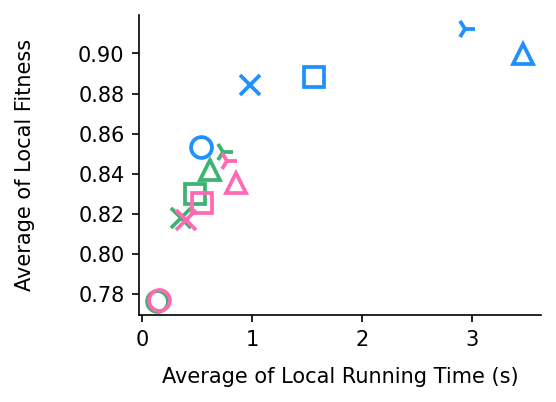

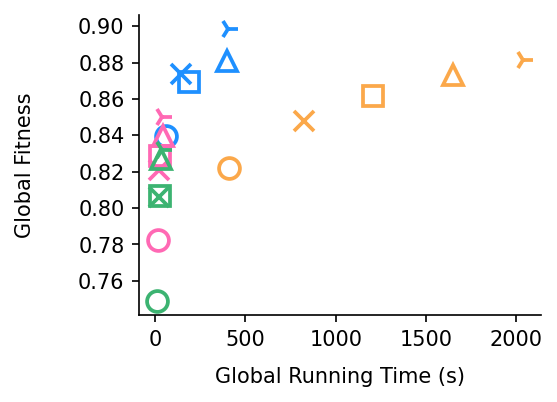

In [435]:
plot(('video10', 'video20', 'video30', 'video40', 'video50'), 'video')

### Stock

In [86]:
import pickle
with open('../Data/index_data.pkl', 'rb') as f:
    index_data = pickle.load(f)

In [22]:
import csv

stock_data = tl.tensor(np.zeros([855, 189, 5], dtype='d'))
start = time.time()
with open('../Data/Stock_.tensor') as file:
    reader = csv.reader(file, delimiter='\t')    
    for row in reader:
        indices = np.asarray([index for index in np.int64(np.asarray(row[:-1]))])[[1, 0, 2]]
        stock_data[tuple(indices)] = np.double(row[-1])
print('>> stock_data loaded ', time.time() - start)

>> stock_data loaded  12.37992000579834


In [264]:
n_iter = 1
ul = 5
ll = 3

In [284]:
tensor_stream = create_tensor_stream(stock_data, start_to_stream=5, batch_sizes=np.full((170), 5, dtype=int))
results['stock2'] = online_tensor_decomposition('stock', stock_data, tensor_stream, rank=2, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['stock3'] = online_tensor_decomposition('stock', stock_data, tensor_stream, rank=3, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['stock4'] = online_tensor_decomposition('stock', stock_data, tensor_stream, rank=4, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['stock5'] = online_tensor_decomposition('stock', stock_data, tensor_stream, rank=5, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
results['stock7'] = online_tensor_decomposition('stock', stock_data, tensor_stream, rank=7, n_iter=n_iter, ul=ul, ll=ll, verbose=False)
# results['stock10'] = online_tensor_decomposition('stock', stock_data, tensor_stream, rank=10, n_iter=n_iter, ul=ul, ll=ll, verbose=False)


-----------------------------------
making init decomposition result: 0.3315165042877197

 >> dao rank-2 n_iter-3
||A-B||: 19.198515257507328
split: 4 refine: 7
global fitness 0.9761288837089706
local fitness 0.9752866691286006
global running time 2.788144588470459
local running time 0.008644805235021254

 >> dtd rank-2 n_iter-3
||A-B||: 19.394011187252392
global fitness 0.9758858073038021
local fitness 0.9745911920630211
global running time 1.2143700122833252
local running time 0.0065918108996223

 >> ocp rank-2 n_iter-3
||A-B||: 19.420084838198292
global fitness 0.9758533877575241
local fitness 0.9746555812812406
global running time 0.5592174530029297
local running time 0.0028185143190271713

 >> fcp rank-2 n_iter-3
global fitness 0.976185285450091
global running time 0.12434673309326172
-----------------------------------
making init decomposition result: 0.2673656940460205

 >> dao rank-3 n_iter-3
||A-B||: 17.99704291448657
split: 11 refine: 13
global fitness 0.9776227745456325
loc

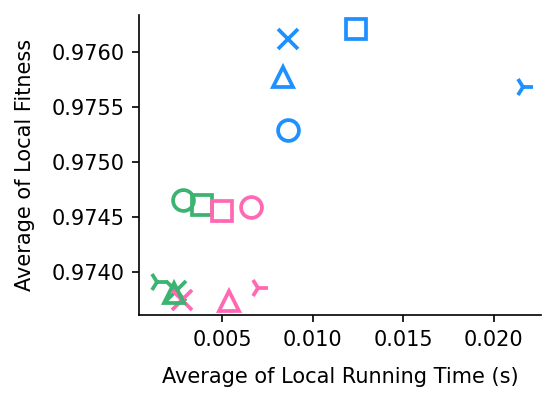

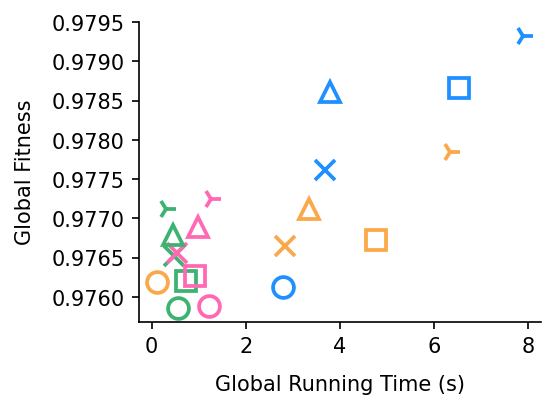

In [434]:
plot(('stock2', 'stock3', 'stock4', 'stock5', 'stock7'), 'stock')

### Plot Results

In [433]:
def plot(datasets, name):

    def plotLocal(min_val=1, max_val=1e4):
        points  = []
        for dataset in datasets:
            if dataset in results:
                for lib in libs:
                    if lib in results[dataset]:
                        point = [lib, dataset, [results[dataset][lib][3]], [results[dataset][lib][1]]]
                        points.append(point)


#         print(points)

        if max_val > 1e+3: ### For brokenaxes
            bax = brokenaxes(xlims=((min_val, 2e4),(20000, 2e5)), d = 0,
                             wspace=0.05,  xscale='log',)
            for point in points :
                lib, data, x, y = point
                if len(x) != 0:
                    if x[0] < 1e+3 + 5000:
                        bax.plot(x, y, label=lib, 
                                 c= dct[lib],  marker=dct1[data],
                                    mfc='none', ms = 10, mew = 1.8)
                    else:
                        x = 50000 
                        bax.plot(x, y, label=lib, 
                                 c= dct[lib],  marker=dct1[data], 
                                mfc='none', ms = 10, mew = 1.8)
        else:  
            bax = brokenaxes(xscale='log')
#             bax = brokenaxes(xscale='log', subplot_spec=sps1)
            for point in points :
                lib, data, x, y = point
                if len(x) != 0:
                    if x[0] != 0 and y[0] != 0:
                        bax.plot(x, y, label=lib,
                                 c= dct[lib],  marker=dct1[data],
                                mfc='none', ms = 10, mew = 1.8)
#         bax.set_ylim([0.97,0.99])
#         bax.set_yscale('log') 
#         bax.set_xscale('log')


#         bax.tick_params(axis = 'y', labelsize =8)
        bax.set_ylabel('Average of Local Fitness', size = 10, labelpad=50)
        bax.set_xlabel('Average of Local Running Time (s)', size = 10, labelpad=25)  ### Labelpad > space btw xaxis and xlabel
        plt.subplots_adjust(hspace=0.1, bottom = 0.4 , left = 0.23, top = 0.9) ### Plot to remove whitespace of plot 
#         plt.show()
        plt.savefig(f'./{name}_local.svg',bbox_inches = 'tight', pad_inches = 0)

    def plotGlobal(min_val=1, max_val=1e4):
        points  = []
        for dataset in datasets:
            if dataset in results:
                for lib in libs:
                    if lib in results[dataset]:
                        point = [lib, dataset, [results[dataset][lib][2]], [results[dataset][lib][0]]]
                        points.append(point)


#         print(points)

        if max_val > 1e+3: ### For brokenaxes
            bax = brokenaxes(xlims=((min_val, 2e4),(20000, 2e5)), d = 0,
                             wspace=0.05,  xscale='log',)
            for point in points :
                lib, data, x, y = point
                if len(x) != 0:
                    if x[0] < 1e+3 + 5000:
                        bax.plot(x, y, label=lib, 
                                 c= dct[lib],  marker=dct1[data],
                                    mfc='none', ms = 10, mew = 1.8)
                    else:
                        x = 50000 
                        bax.plot(x, y, label=lib, 
                                 c= dct[lib],  marker=dct1[data], 
                                mfc='none', ms = 10, mew = 1.8)
        else:  
            bax = brokenaxes(xscale='log')
#             bax = brokenaxes(xscale='log', subplot_spec=sps2)
            for point in points :
                lib, data, x, y = point
                if len(x) != 0:
                    if x[0] != 0 and y[0] != 0:
                        bax.plot(x, y, label=lib,
                                 c= dct[lib],  marker=dct1[data],
                                mfc='none', ms = 10, mew = 1.8)

#         bax.set_ylim([0.97,0.99])
#         bax.set_xscale('log') 
        bax.set_ylabel('Global Fitness', size = 10, labelpad=50)
        bax.set_xlabel('Global Running Time (s)', size = 10, labelpad=25)  ### Labelpad > space btw xaxis and xlabel
        plt.subplots_adjust(hspace=0.1, bottom = 0.4 , left = 0.23, top = 0.9) ### Plot to remove whitespace of plot 
#         plt.show()
        plt.savefig(f'./{name}_global.svg',bbox_inches = 'tight', pad_inches = 0)

    markers = ("o", "x", "s", "^", "4")
    colors = ('dodgerblue','mediumseagreen', 'hotpink', '#fba84a')

    libs = ("dao", "ocp", "dtd", "fcp")
    f = lambda m,c: plt.plot([],[], color=c, marker = m,
                             mfc='none', ms = 10, mew = 1.8,
                                ls="none")[0]
    f2 = lambda c: plt.plot([],[],marker='.', color=c, )[0]

    dct = {}
    dct1 = {}

    for color, lib in zip(colors, libs):
        dct[lib] = color

    for data, marker in zip(datasets, markers):
        dct1[data] = marker
    
    fig = plt.figure(figsize = (4, 4), dpi = 150,)   ### figsize = (row, col), dpi > resolution(?)
#     sps1, sps2 = GridSpec(1,2)
    plotLocal(max_val=100)
    fig = plt.figure(figsize = (4, 4), dpi = 150,)   ### figsize = (row, col), dpi > resolution(?)
    plotGlobal(max_val=100)